## 0. Imports and Setup

In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotly import express as px

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

from sklearn.linear_model import Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('forex_rate_fcst_latin_data_trimmed_23-08-18.csv', index_col = 0, parse_dates=True)

## 1. Propose window transformations on those highly-autocorrelated features

Notion:
1. These series needs to be taken return/differences as they are highly correlated. Using their raw value (bbg commd.prices at 100) doesn't really add explainable values when it comes to predicting the return of the CLP/USD
2. Different series have difference resolution - e.g. GDP daily change/ monthly change does't really produce any meaningful numbers
3. Porpose sensible windows for each series and then just use correlation to select the window transformation that has the strongest correlation with the target of interest

In [7]:
end_of_training= '2021-06-01' # ROUGHLY 60% TRAINING, 40% TESTING SPLIT - leave 2 years window untouched

In [8]:
def transform_select_features_per_column(
    column: str, 
    release_frequency: str,        # series monthly or weekly or quarterly
    time_delta: int,               # Forecasting time-delta
    target_column: str,            # target column
    data: pd.DataFrame,            # only using training set
    selection_cut_off_datestamp: str,  
    testing_method: str='spearman' # rank-based correlation test
):

    '''A simple quick helper function that propose the window transformations
    for a particular column. And select the top feature based on spearman 
    correlation with the shifted target (prediction time delta) in a set 
    timeframe (i.e feature not selected across the entire time period, but
    rather at the end of training.
    No need to care about scaling at this stage, as using spearman (rank-based)
    this is not the most memory efficient way of doing things
    '''
    
    # Define windows for smoothing or taking returns or diffs
    # care about the release frequency as e.g it's pointless to take weekly return for quarterly-resoluted columns
    if release_frequency == 'weekly':
        testing_window = [7, 14, 30, 60, 90]
    elif release_frequency == 'monthly':
        testing_window = [30, 60, 90]
    elif release_frequency == 'quarterly':
        testing_window = [90, 90*2, 90*3, 90*4] 
    else: # daily
        testing_window = [7, 14, 30, 60, 90]
    
    # Generate those series based on the windows
    all_series = []
    all_corr = []
    for win in testing_window: 
        for method in ['difference', 'return']:
            series_name = f'{column} {win}-step {method}'
            if method=='difference':
                test_series = pd.Series(data[column].diff(win),
                     name= series_name)
            else:
                test_series =pd.Series(data[column].pct_change(win),
                                      name=series_name)

            spearman_corr = pd.concat([test_series, data[target_column]], axis=1)\
                .loc[:selection_cut_off_datestamp]\
                .assign(shifted_modelling_target = lambda d: d[target_column].pct_change(time_delta).shift(-time_delta))\
                .drop(columns=[target_column])\
                .corr(method='spearman')['shifted_modelling_target'].iloc[0]
            
            all_series.append(test_series)
            all_corr.append(spearman_corr)

    # Getting the highest spearman score (abs) and return the series
    best_spearman_index = pd.Series(all_corr).abs().idxmax()

    return all_series[best_spearman_index]

In [9]:
column_freq_dict = {
    'Net trade in goods (value)_Chile': 'monthly',
     'Net trade in goods (value)_United States': 'monthly',
     'Exports in goods (value)_Chile': 'monthly',
     'Exports in goods (value)_United States': 'monthly',
     'Imports in goods (value)_Chile': 'monthly',
     'Imports in goods (value)_United States': 'monthly',
     'Insured Unemployment Rate': 'weekly',
     'Chicago Fed National Financial Conditions Index': 'weekly',
     'Federal Funds Effective Rate':'daily',
     'Equity Market-related Economic Uncertainty Index': 'daily',
     'Economic Policy Uncertainty Index for United States': 'daily',
     'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average': 'monthly',
     'Consumer Price Index: All Items: Total: Total for Chile': 'monthly',
     'Unemployment Rate: Aged 15 and over: All Persons for Chile': 'monthly',
     'U.S. Exports of Goods by F.A.S. Basis to Chile': 'monthly',
     'U.S. Imports of Goods by Customs Basis from Chile': 'monthly',
     'GDP_United States':'quarterly',
     'GDP_Chile': 'quarterly',
     'Interest Rate_Chile':'daily',
     'SP500':'daily',
     'VIX':'daily',
     'BBG_Comm_Index':'daily',
     'BBG_Agriculture_Index':'daily',
     'BBG_Aluminum_Index':'daily',
     'BBG_Soybeans_Index':'daily',
     'BBG_SoybeansOil_Index':'daily',
     'BBG_Copper_Index':'daily',
     'BBG_Coffee_Index':'daily',
     'BBG_Cocoa_Index':'daily',
     'Crude Oil Commodity':'daily',
     'Brent Crude Commodity':'daily',
     'US GBond 1M':'daily',
     'US GBond 6M':'daily',
     'US GBond 1Y':'daily',
     'US GBond 2Y':'daily',
     'US GBond 5Y':'daily',
     'US GBond 10Y':'daily',
     'US GBond 30Y':'daily',
     'Chile GBond 10Y':'daily',
     'S&P CLX IPSA':'daily',
     'GDP_QoQ_diff_Chile_US':'daily',
     'ir_diff_Chile_US':'daily',
     'inflation_MoM_diff_Chile_US': 'monthly',
     'yield_spread_30Y_6M':'daily',
     'yield_spread_Chile_US_10Y':'daily',
     'import_export_total_Chile': 'monthly',
     'import_export_total_US': 'monthly',
}

In [10]:
# 7 days forecasting horizon
initial_screening_7_steps =[]
for col, freq in column_freq_dict.items():
    best_series = transform_select_features_per_column(column = col, 
                                                       release_frequency=freq, 
                                                       time_delta=7, 
                                                       target_column='CLPUSD_wins', 
                                                       data =data,
                                                        selection_cut_off_datestamp=end_of_training, 
                                                        testing_method='spearman')
    initial_screening_7_steps.append(best_series)

initial_screening_7_steps_features_df = pd.concat(initial_screening_7_steps, axis = 1).join(data['CLPUSD_wins'])

In [11]:
# 30 days forecasting horizon
initial_screening_30_steps =[]
for col, freq in column_freq_dict.items():
    best_series = transform_select_features_per_column(column = col, 
                                                       release_frequency=freq, 
                                                       time_delta=30, 
                                                       target_column='CLPUSD_wins', 
                                                        data =data,
                                                        selection_cut_off_datestamp=end_of_training, 
                                                        testing_method='spearman')
    initial_screening_30_steps.append(best_series)

initial_screening_30_steps_features_df = pd.concat(initial_screening_30_steps, axis = 1).join(data['CLPUSD_wins'])

### 2. Taking a look at the correlations to get a sense from the selected window transformation

In [12]:
# 7 steps forecasting
initial_screening_7_steps_features_df\
    .loc[:end_of_training]\
    .assign(modelling_target = lambda d: d['CLPUSD_wins'].shift(-7).pct_change(7))\
    .drop(columns=['CLPUSD_wins'])\
    .corr(method='spearman')\
    [['modelling_target']]\
    .sort_values(by='modelling_target', key = np.abs, ascending=False)\
    .iloc[1:, :]\
    .style.bar(color='lightblue')

,modelling_target
import_export_total_Chile 30-step return,0.212750
Exports in goods (value)_Chile 30-step difference,0.172003
GDP_United States 360-step difference,-0.167951
Imports in goods (value)_Chile 30-step difference,0.165488
S&P CLX IPSA 14-step difference,0.165455
BBG_Comm_Index 7-step difference,0.159668
BBG_Copper_Index 7-step difference,0.154675
Crude Oil Commodity 7-step return,0.142852
Consumer Price Index: All Items: Total: Total for Chile 30-step difference,-0.140112
Net trade in goods (value)_United States 90-step difference,-0.140011


In [13]:
# 30 steps forecasting
initial_screening_30_steps_features_df\
    .loc[:end_of_training]\
    .assign(modelling_target = lambda d: d['CLPUSD_wins'].pct_change(30).shift(-30))\
    .drop(columns=['CLPUSD_wins'])\
    .corr(method='spearman')\
    [['modelling_target']]\
    .sort_values(by='modelling_target', key = np.abs, ascending=False)\
    .iloc[1:, :]\
    .style.bar(color='lightblue')

,modelling_target
GDP_United States 270-step difference,-0.329022
import_export_total_Chile 30-step difference,0.285857
GDP_QoQ_diff_Chile_US 90-step difference,0.274201
Net trade in goods (value)_United States 90-step difference,-0.271993
GDP_Chile 90-step return,0.259851
Exports in goods (value)_Chile 30-step difference,0.259038
BBG_Cocoa_Index 60-step difference,-0.252723
Consumer Price Index: All Items: Total: Total for Chile 30-step difference,-0.223355
S&P CLX IPSA 14-step difference,0.192506
Imports in goods (value)_United States 30-step difference,0.189911


### 2. Clustering to select the top features
Notion:
1. Some features are still correlated with each other (e.g. BBG Agriculture are 80% correlated with BBG Soybean). This means adding both doesn't really add values to the model. So I am selecting one over another
2. Evaluate the feature-feature association and perform clustering. For each cluster, select the top one in the cluster

#### 2.1: 7 Steps

In [21]:
feat_feat_corr_7_steps = initial_screening_7_steps_features_df\
    .loc[:end_of_training]\
    .drop(columns=['CLPUSD_wins'])\
    .corr(method='spearman')

feat_feat_corr_7_steps.style.bar(color='lightblue')

In [23]:
# feature target association
feat_target_corr_7_steps = initial_screening_7_steps_features_df\
                        .loc[:end_of_training]\
                        .assign(modelling_target = lambda d: d['CLPUSD_wins'].pct_change(7).shift(-7))\
                        .drop(columns=['CLPUSD_wins'])\
                        .corr(method='spearman')\
                        ['modelling_target']

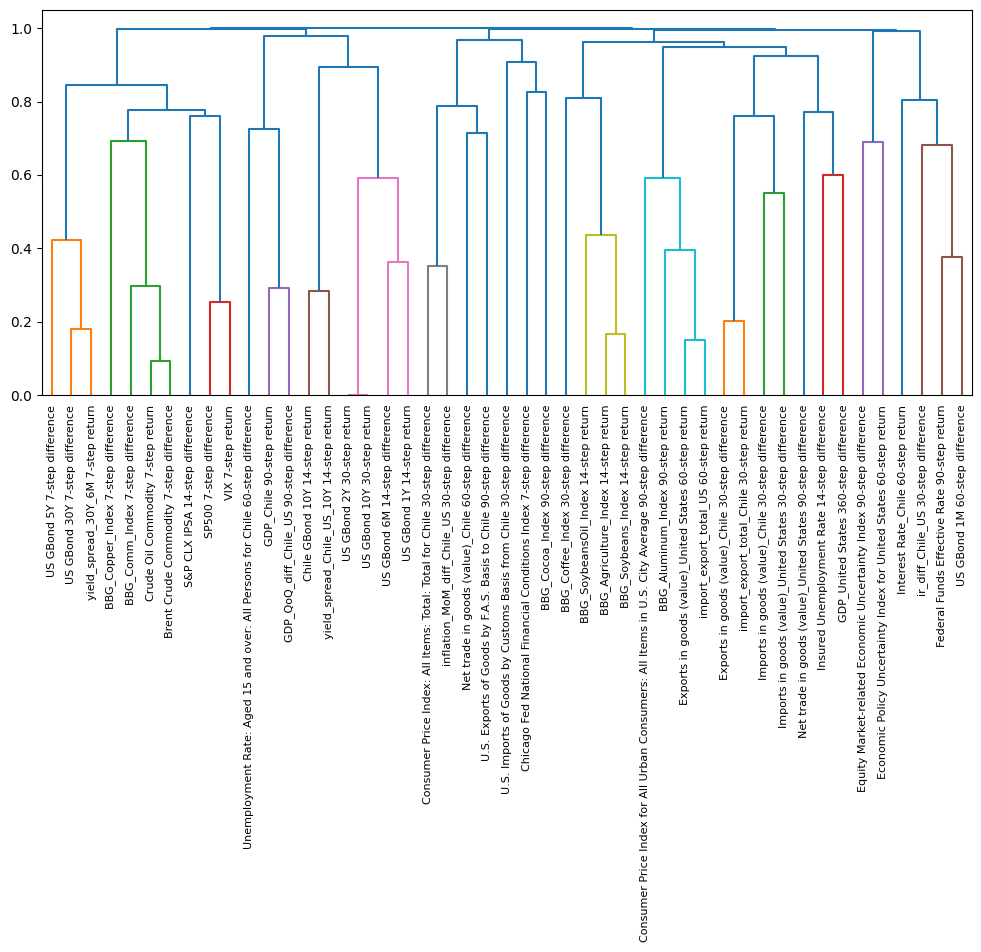

In [24]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(feat_feat_corr_7_steps)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=feat_feat_corr_7_steps.columns, orientation='top', 
           leaf_rotation=90);

In [51]:
clusters_7_steps = pd.Series(fcluster(Z, 0.8, criterion='distance'), 
                            name = 'cluster', 
                            index = feat_feat_corr_7_steps.columns)
clustered_feat_7_steps = {}
clustered_feat_7_steps_corr={}
for i in clusters_7_step.unique():
    # getting the highest correlaton (taking abs)
    col = feat_target_corr_7_steps[clusters_7_steps.loc[lambda s: s==i].index.to_list()].abs().idxmax()
    # Getting its correlation then
    cor = feat_target_corr_7_steps[col]
    
    clustered_feat_7_steps_corr[col]=cor
    clustered_feat_7_steps[i] = clusters_7_steps.loc[lambda s: s==i].index.to_list()

In [52]:
# View how they are clusted to see if they make sense
pd.DataFrame.from_dict(clustered_feat_7_steps, orient='index').T.style

,6,14,13,12,7,16,15,3,9,17,2,10,11,8,5,1,4
0,Net trade in goods (value)_Chile 60-step difference,Net trade in goods (value)_United States 90-step difference,Exports in goods (value)_Chile 30-step difference,Exports in goods (value)_United States 60-step return,Chicago Fed National Financial Conditions Index 7-step difference,Federal Funds Effective Rate 90-step return,Equity Market-related Economic Uncertainty Index 90-step difference,Unemployment Rate: Aged 15 and over: All Persons for Chile 60-step difference,U.S. Imports of Goods by Customs Basis from Chile 30-step difference,Interest Rate_Chile 60-step return,SP500 7-step difference,BBG_Agriculture_Index 14-step return,BBG_Coffee_Index 30-step difference,BBG_Cocoa_Index 90-step difference,US GBond 6M 14-step difference,US GBond 5Y 7-step difference,Chile GBond 10Y 14-step return
1,Consumer Price Index: All Items: Total: Total for Chile 30-step difference,Insured Unemployment Rate 14-step difference,Imports in goods (value)_Chile 30-step difference,Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 90-step difference,None,US GBond 1M 60-step difference,Economic Policy Uncertainty Index for United States 60-step return,GDP_Chile 90-step return,None,None,VIX 7-step return,BBG_Soybeans_Index 14-step return,None,None,US GBond 1Y 14-step return,US GBond 30Y 7-step difference,yield_spread_Chile_US_10Y 14-step return
2,U.S. Exports of Goods by F.A.S. Basis to Chile 90-step difference,GDP_United States 360-step difference,Imports in goods (value)_United States 30-step difference,BBG_Aluminum_Index 90-step return,None,ir_diff_Chile_US 30-step difference,None,GDP_QoQ_diff_Chile_US 90-step difference,None,None,BBG_Comm_Index 7-step difference,BBG_SoybeansOil_Index 14-step return,None,None,US GBond 2Y 30-step return,yield_spread_30Y_6M 7-step return,None
3,inflation_MoM_diff_Chile_US 30-step difference,None,import_export_total_Chile 30-step return,import_export_total_US 60-step return,None,None,None,None,None,None,BBG_Copper_Index 7-step difference,None,None,None,US GBond 10Y 30-step return,None,None
4,None,None,None,None,None,None,None,None,None,None,Crude Oil Commodity 7-step return,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,Brent Crude Commodity 7-step difference,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,S&P CLX IPSA 14-step difference,None,None,None,None,None,None


In [53]:
pd.DataFrame.from_dict(clustered_feat_7_steps_corr, orient='index')\
    .sort_values(by=0, ascending=False, key = np.abs)\
    .style.bar(color='lightblue')

,0
import_export_total_Chile 30-step return,0.212056
S&P CLX IPSA 14-step difference,0.167994
GDP_United States 360-step difference,-0.166367
Consumer Price Index: All Items: Total: Total for Chile 30-step difference,-0.141462
BBG_Cocoa_Index 90-step difference,-0.114383
BBG_Soybeans_Index 14-step return,0.111352
Chicago Fed National Financial Conditions Index 7-step difference,-0.111235
import_export_total_US 60-step return,0.110203
ir_diff_Chile_US 30-step difference,-0.098111
GDP_Chile 90-step return,0.089725


In [61]:
clustered_features_7_steps = list(clustered_feat_7_steps_corr.keys())

# Hancrafting - swapping in some features in the same cluster that would make more sense
clustered_features_7_steps.remove('GDP_Chile 90-step return')
clustered_features_7_steps.append('GDP_QoQ_diff_Chile_US 90-step difference')

clustered_features_7_steps.remove('US GBond 30Y 7-step difference')
clustered_features_7_steps.append('yield_spread_30Y_6M 7-step return')

clustered_features_7_steps.remove('Chile GBond 10Y 14-step return')
clustered_features_7_steps.append('yield_spread_Chile_US_10Y 14-step return')

#### 2.2. 30-steps

In [62]:
feat_feat_corr_30_steps = initial_screening_30_steps_features_df\
    .loc[:end_of_training]\
    .drop(columns=['CLPUSD_wins'])\
    .corr(method='spearman')

feat_feat_corr_30_steps.style.bar(color='lightblue')

In [63]:
# feature target association
feat_target_corr_30_steps = initial_screening_30_steps_features_df\
                        .loc[:end_of_training]\
                        .assign(modelling_target = lambda d: d['CLPUSD_wins'].pct_change(30).shift(-30))\
                        .drop(columns=['CLPUSD_wins'])\
                        .corr(method='spearman')\
                        ['modelling_target']

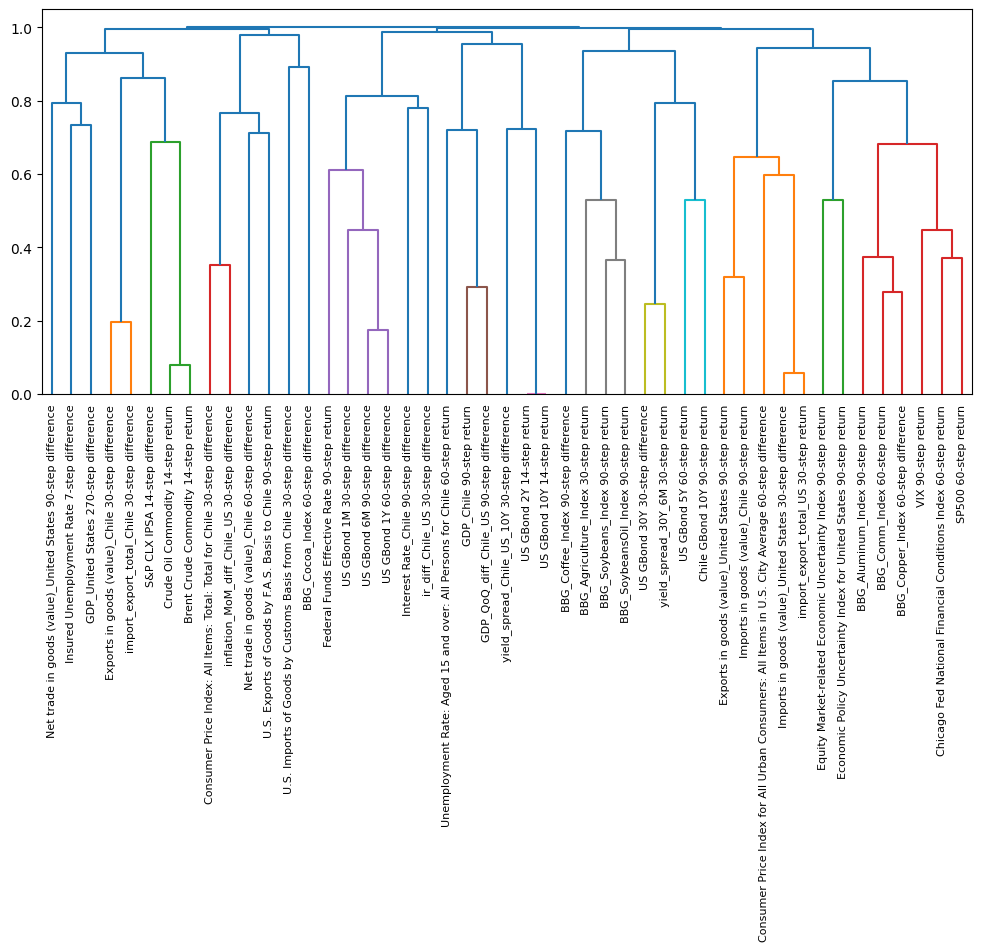

In [64]:
plt.figure(figsize=(12,5))
dissimilarity_30 = 1 - abs(feat_feat_corr_30_steps)
Z_30 = linkage(squareform(dissimilarity_30), 'complete')

dendrogram(Z_30, labels=feat_feat_corr_30_steps.columns, orientation='top', 
           leaf_rotation=90);

In [66]:
clusters_30_steps = pd.Series(fcluster(Z_30, 0.8, criterion='distance'), 
                            name = 'cluster', 
                            index = feat_feat_corr_30_steps.columns)
clustered_feat_30_steps = {}
clustered_feat_30_steps_corr={}
for i in clusters_30_steps.unique():
    # getting the highest correlaton (taking abs)
    col = feat_target_corr_30_steps[clusters_30_steps.loc[lambda s: s==i].index.to_list()].abs().idxmax()
    # Getting its correlation then
    cor = feat_target_corr_30_steps[col]
    
    clustered_feat_30_steps_corr[col]=cor
    clustered_feat_30_steps[i] = clusters_30_steps.loc[lambda s: s==i].index.to_list()

In [67]:
# View how they are clusted to see if they make sense
pd.DataFrame.from_dict(clustered_feat_30_steps, orient='index').T.style

,4,1,2,13,15,7,14,9,5,8,11,6,3,10,12
0,Net trade in goods (value)_Chile 60-step difference,Net trade in goods (value)_United States 90-step difference,Exports in goods (value)_Chile 30-step difference,Exports in goods (value)_United States 90-step return,Chicago Fed National Financial Conditions Index 60-step return,Federal Funds Effective Rate 90-step return,Equity Market-related Economic Uncertainty Index 90-step return,Unemployment Rate: Aged 15 and over: All Persons for Chile 60-step return,U.S. Imports of Goods by Customs Basis from Chile 30-step difference,Interest Rate_Chile 90-step difference,BBG_Agriculture_Index 30-step return,BBG_Cocoa_Index 60-step difference,Crude Oil Commodity 14-step return,US GBond 2Y 14-step return,US GBond 5Y 60-step return
1,Consumer Price Index: All Items: Total: Total for Chile 30-step difference,Insured Unemployment Rate 7-step difference,import_export_total_Chile 30-step difference,Imports in goods (value)_Chile 90-step return,SP500 60-step return,US GBond 1M 30-step difference,Economic Policy Uncertainty Index for United States 90-step return,GDP_Chile 90-step return,None,ir_diff_Chile_US 30-step difference,BBG_Soybeans_Index 90-step return,None,Brent Crude Commodity 14-step return,US GBond 10Y 14-step return,US GBond 30Y 30-step difference
2,U.S. Exports of Goods by F.A.S. Basis to Chile 90-step return,GDP_United States 270-step difference,None,Imports in goods (value)_United States 30-step difference,VIX 90-step return,US GBond 6M 90-step difference,None,GDP_QoQ_diff_Chile_US 90-step difference,None,None,BBG_SoybeansOil_Index 90-step return,None,S&P CLX IPSA 14-step difference,yield_spread_Chile_US_10Y 30-step difference,Chile GBond 10Y 90-step return
3,inflation_MoM_diff_Chile_US 30-step difference,None,None,Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 60-step difference,BBG_Comm_Index 60-step return,US GBond 1Y 60-step difference,None,None,None,None,BBG_Coffee_Index 90-step difference,None,None,None,yield_spread_30Y_6M 30-step return
4,None,None,None,import_export_total_US 30-step return,BBG_Aluminum_Index 90-step return,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,BBG_Copper_Index 60-step difference,None,None,None,None,None,None,None,None,None,None


In [68]:
pd.DataFrame.from_dict(clustered_feat_30_steps_corr, orient='index')\
    .sort_values(by=0, ascending=False, key = np.abs)\
    .style.bar(color='lightblue')

,0
GDP_United States 270-step difference,-0.329022
import_export_total_Chile 30-step difference,0.285857
GDP_QoQ_diff_Chile_US 90-step difference,0.274201
BBG_Cocoa_Index 60-step difference,-0.252723
Consumer Price Index: All Items: Total: Total for Chile 30-step difference,-0.223355
S&P CLX IPSA 14-step difference,0.192506
Imports in goods (value)_United States 30-step difference,0.189911
US GBond 1M 30-step difference,0.162398
BBG_Copper_Index 60-step difference,0.158980
BBG_Soybeans_Index 90-step return,0.132102


In [69]:
clustered_features_30_steps = list(clustered_feat_30_steps_corr.keys())

In [114]:
df_train_7_steps.columns

Index(['Consumer Price Index: All Items: Total: Total for Chile 30-step difference',
       'GDP_United States 360-step difference',
       'import_export_total_Chile 30-step return',
       'import_export_total_US 60-step return',
       'Chicago Fed National Financial Conditions Index 7-step difference',
       'ir_diff_Chile_US 30-step difference',
       'Economic Policy Uncertainty Index for United States 60-step return',
       'U.S. Imports of Goods by Customs Basis from Chile 30-step difference',
       'Interest Rate_Chile 60-step return', 'S&P CLX IPSA 14-step difference',
       'BBG_Soybeans_Index 14-step return',
       'BBG_Coffee_Index 30-step difference',
       'BBG_Cocoa_Index 90-step difference', 'US GBond 2Y 30-step return',
       'GDP_QoQ_diff_Chile_US 90-step difference',
       'yield_spread_30Y_6M 7-step return',
       'yield_spread_Chile_US_10Y 14-step return', 'modelling_target'],
      dtype='object')

### 3. Random Forest to eliminate some features that are less important

In [130]:
final_data_7_days = initial_screening_7_steps_features_df[clustered_features_7_steps]\
                    .join(data['CLPUSD_wins'])\
                    .assign(modelling_target = lambda d: d['CLPUSD_wins'].pct_change(7).shift(-7))\
                    .drop(columns=['CLPUSD_wins'])\
                    .replace([np.inf, -np.inf], np.nan)

# Split train-test
df_train_7_steps = final_data_7_days.loc[:end_of_training].dropna()
df_test_7_steps = final_data_7_days.loc[end_of_training:].dropna()

X_train_7_steps = df_train_7_steps.drop("modelling_target", axis=1)
y_train_7_steps = df_train_7_steps["modelling_target"]  
X_test_7_steps = df_test_7_steps.drop("modelling_target", axis=1)
y_test_7_steps = df_test_7_steps["modelling_target"]

scaler = StandardScaler()
scaler.fit(X_train_7_steps)
X_train_7_steps_scaled = scaler.transform(X_train_7_steps)
X_test_7_steps_scaled = scaler.transform(X_test_7_steps)

rfe = RandomForestRegressor()
rfe.fit(X_train_7_steps_scaled, y_train_7_steps)

rfe_importance_df = pd.DataFrame({'Features': X_train_7_steps.columns,
                                  'Importance': rfe.feature_importances_
                                 }).sort_values(by='Importance', ascending=False)
rfe_importance_df.style.bar(color='lightblue')

,Features,Importance
4,Chicago Fed National Financial Conditions Index 7-step difference,0.114617
12,BBG_Cocoa_Index 90-step difference,0.103589
16,yield_spread_Chile_US_10Y 14-step return,0.090671
13,US GBond 2Y 30-step return,0.090513
9,S&P CLX IPSA 14-step difference,0.086215
2,import_export_total_Chile 30-step return,0.080983
10,BBG_Soybeans_Index 14-step return,0.075657
11,BBG_Coffee_Index 30-step difference,0.074992
15,yield_spread_30Y_6M 7-step return,0.062641
6,Economic Policy Uncertainty Index for United States 60-step return,0.039838


In [185]:
rfe_importance_df.join(feat_target_corr_7_steps, on = 'Features')\
    [['Features','modelling_target', 'Importance']]\
    .rename(columns={'modelling_target': 'spearman_correlation', 'Importance': 'feature_importance'})\
    .sort_values(by = 'spearman_correlation', key = np.abs, ascending=False)\
    .drop(columns=['feature_importance'])\
    .style.bar(color = 'lightblue')

,Features,spearman_correlation
2,import_export_total_Chile 30-step return,0.212056
9,S&P CLX IPSA 14-step difference,0.167994
1,GDP_United States 360-step difference,-0.166367
0,Consumer Price Index: All Items: Total: Total for Chile 30-step difference,-0.141462
12,BBG_Cocoa_Index 90-step difference,-0.114383
10,BBG_Soybeans_Index 14-step return,0.111352
4,Chicago Fed National Financial Conditions Index 7-step difference,-0.111235
3,import_export_total_US 60-step return,0.110203
5,ir_diff_Chile_US 30-step difference,-0.098111
14,GDP_QoQ_diff_Chile_US 90-step difference,0.079388


In [135]:
# eliminating the last 5 features from here 
final_7_days_features = rfe_importance_df.iloc[:-5]['Features'].to_list()
final_7_days_features

['Chicago Fed National Financial Conditions Index 7-step difference',
 'BBG_Cocoa_Index 90-step difference',
 'yield_spread_Chile_US_10Y 14-step return',
 'US GBond 2Y 30-step return',
 'S&P CLX IPSA 14-step difference',
 'import_export_total_Chile 30-step return',
 'BBG_Soybeans_Index 14-step return',
 'BBG_Coffee_Index 30-step difference',
 'yield_spread_30Y_6M 7-step return',
 'Economic Policy Uncertainty Index for United States 60-step return',
 'Consumer Price Index: All Items: Total: Total for Chile 30-step difference',
 'import_export_total_US 60-step return']

In [133]:
final_data_30_days = initial_screening_30_steps_features_df[clustered_features_30_steps]\
                    .join(data['CLPUSD_wins'])\
                    .assign(modelling_target = lambda d: d['CLPUSD_wins'].pct_change(30).shift(-30))\ # I am at most leaking 30 days from test to train here
                    .drop(columns=['CLPUSD_wins'])\
                    .replace([np.inf, -np.inf], np.nan)

# Split train-test
df_train_30_steps = final_data_30_days.loc[:end_of_training].dropna()
df_test_30_steps = final_data_30_days.loc[end_of_training:].dropna()

X_train_30_steps = df_train_30_steps.drop("modelling_target", axis=1)
y_train_30_steps = df_train_30_steps["modelling_target"]  
X_test_30_steps = df_test_30_steps.drop("modelling_target", axis=1)
y_test_30_steps = df_test_30_steps["modelling_target"]

scaler = StandardScaler()
scaler.fit(X_train_30_steps)
X_train_30_steps_scaled = scaler.transform(X_train_30_steps)
X_test_30_steps_scaled = scaler.transform(X_test_30_steps)

rfe_30 = RandomForestRegressor()
rfe_30.fit(X_train_30_steps_scaled, y_train_30_steps)

rfe__30_importance_df = pd.DataFrame({'Features': X_train_30_steps.columns,
                                  'Importance': rfe_30.feature_importances_
                                 }).sort_values(by='Importance', ascending=False)
rfe__30_importance_df.style.bar(color='lightblue')

,Features,Importance
1,GDP_United States 270-step difference,0.135926
14,yield_spread_30Y_6M 30-step return,0.097828
7,GDP_QoQ_diff_Chile_US 90-step difference,0.091112
3,Imports in goods (value)_United States 30-step difference,0.091111
13,yield_spread_Chile_US_10Y 30-step difference,0.084816
10,BBG_Soybeans_Index 90-step return,0.069692
11,BBG_Cocoa_Index 60-step difference,0.068927
2,import_export_total_Chile 30-step difference,0.066306
0,Consumer Price Index: All Items: Total: Total for Chile 30-step difference,0.061301
4,BBG_Copper_Index 60-step difference,0.054167


In [184]:
rfe__30_importance_df.join(feat_target_corr_30_steps, on = 'Features')\
    [['Features','modelling_target', 'Importance']]\
    .rename(columns={'modelling_target': 'spearman_correlation', 'Importance': 'feature_importance'})\
    .drop(columns=['feature_importance'])\
    .sort_values(by = 'spearman_correlation', key = np.abs, ascending=False)\
    .style.bar(color='lightblue')

,Features,spearman_correlation
1,GDP_United States 270-step difference,-0.329022
2,import_export_total_Chile 30-step difference,0.285857
7,GDP_QoQ_diff_Chile_US 90-step difference,0.274201
11,BBG_Cocoa_Index 60-step difference,-0.252723
0,Consumer Price Index: All Items: Total: Total for Chile 30-step difference,-0.223355
12,S&P CLX IPSA 14-step difference,0.192506
3,Imports in goods (value)_United States 30-step difference,0.189911
5,US GBond 1M 30-step difference,0.162398
4,BBG_Copper_Index 60-step difference,0.158980
10,BBG_Soybeans_Index 90-step return,0.132102


In [137]:
# eliminating the last 30 features from here 
final_30_days_features = rfe__30_importance_df.iloc[:-5]['Features'].to_list()
final_30_days_features

['GDP_United States 270-step difference',
 'yield_spread_30Y_6M 30-step return',
 'GDP_QoQ_diff_Chile_US 90-step difference',
 'Imports in goods (value)_United States 30-step difference',
 'yield_spread_Chile_US_10Y 30-step difference',
 'BBG_Soybeans_Index 90-step return',
 'BBG_Cocoa_Index 60-step difference',
 'import_export_total_Chile 30-step difference',
 'Consumer Price Index: All Items: Total: Total for Chile 30-step difference',
 'BBG_Copper_Index 60-step difference']

In [152]:
#### Exporting these features and data for next step modellig
final_data_7_days = initial_screening_7_steps_features_df[final_7_days_features]\
                    .join(data['CLPUSD_wins'])\

final_data_30_days = initial_screening_30_steps_features_df[final_30_days_features]\
                    .join(data['CLPUSD_wins'])\

final_data_7_days.to_csv('clp_usd_modelling_data_7_days.csv')
final_data_30_days.to_csv('clp_usd_modelling_data_30_days.csv')